## Esercizi

1. Caricare il dataset visto nella lezione precedente e dividerlo in train e test set
2. Creare un sistema di Cross Validation con 3 Fold
3. Scegliere un hyperparameter del quale si vuole fare tuning, e creare le relativi reti da allenare
4. Allenare queste reti e validarle usando Cross Validation
5. Scegliere la rete migliore
6. Allenare nuovamente la rete con gli hyperparameters scelti con un nuovo validation set e Early Stopping
7. Testare la rete ottenuta

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import copy
from statistics import mean
from dataclasses import dataclass, field
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/My\ Drive/PYTORCH/slides/Sezione\ 3/Esercitazione

/gdrive/.shortcut-targets-by-id/1eK5EFDQDPmk-HXdkS1PVUWdCbx1DthUN/PYTORCH/slides/Sezione 3/Esercitazione


In [ ]:
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)

1. Caricare il dataset visto nella lezione precedente e dividerlo in train e test set

In [ ]:
path = "datasets/winequality.csv"
df = pd.read_csv(path)
df = df.dropna()
df["type"] = df["type"].map(lambda x: 1 if x =="red" else 0)

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(df[df.columns[:-1]],
                                                            pd.DataFrame(df['quality'],
                                                                         columns=['quality']),
                                                            test_size = 0.1, random_state=seed,
                                                            stratify=pd.DataFrame(df['quality'], columns=['quality']))
print(X_train_val.shape, y_train_val.shape)
print(X_test.shape, y_test.shape)

(5816, 12) (5816, 1)
(647, 12) (647, 1)


In [ ]:
max_df = X_train_val.max()
min_df = X_train_val.min()

max_t = y_train_val.max()
min_t = y_train_val.min()

X_train_val = (X_train_val - min_df)/(max_df - min_df)
y_train_val = (y_train_val - min_t)/(max_t - min_t)

In [ ]:
#Applichiamo la normalizzazione al test set
X_test = (X_test - min_df)/(max_df - min_df)
y_test = (y_test - min_t)/(max_t - min_t)

In [ ]:
# Reset degli indici
X_train_val = X_train_val.reset_index().drop(columns=['index'])
X_test = X_test.reset_index().drop(columns=['index'])


y_train_val = y_train_val.reset_index().drop(columns=['index'])
y_test= y_test.reset_index().drop(columns=['index'])


In [ ]:
# Creazione datasets
trainval_dataset = data_utils.TensorDataset(torch.tensor(X_train_val.values, dtype = torch.float32), torch.tensor(y_train_val.values, dtype = torch.float32))
test_dataset = data_utils.TensorDataset(torch.tensor(X_test.values, dtype = torch.float32), torch.tensor(y_test.values, dtype = torch.float32))


2. Creare un sistema di Cross Validation con 3 Fold

In [ ]:
n_splits = 3
batch_size = 256

kf = KFold(n_splits=n_splits, shuffle=True)


In [ ]:
fold_loaders = []
for fold, (train_idx, test_idx) in enumerate(kf.split(trainval_dataset)):

    trainloader = data_utils.DataLoader(trainval_dataset,
                                           batch_size=batch_size,
                                           sampler=torch.utils.data.SubsetRandomSampler(train_idx))
    valloader = data_utils.DataLoader(
        dataset=trainval_dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(test_idx)
    )

    fold_loaders.append({
        "trainloader":trainloader,
        "valloader":valloader
    })

In [ ]:
@dataclass
class Experiment:
  "Questa classe rappresenta tutti gli hyperparameters e il modello di ogni esperimento"
  name: str
  checkpoints_folder: str
  checkpoint_name:str
  model: object
  use_early_stopping: bool
  loss_fn : object
  color: str
  alpha: float
  optimizer: object
  checkpoint_save_path: str = None
  val_mse: float = None
  trainloader: object = None
  valloader: object = None
  lr: float = 1e-5
  epochs: int = 600
  patience: int = 10
  min_delta: float = 0
  epoch_count: list = field(default_factory=list)
  val_loss_values: list = field(default_factory=list)
  train_loss_values: list = field(default_factory=list)
  plt_args_training: dict = field(default_factory=dict)
  plt_args_validation: dict = field(default_factory=dict)

  def __post_init__(self):
    self.model = self.model()
    self.optimizer = self.optimizer(params=self.model.parameters(),
                            lr=self.lr)

In [ ]:
@dataclass
class FoldExperiment(Experiment):
  fold_number: int = 0

  def __post_init__(self):

    self.checkpoints_folder = os.path.join(self.checkpoints_folder, self.name, f"fold_{str(self.fold_number)}")
    os.makedirs(self.checkpoints_folder, exist_ok = True)
    self.checkpoint_save_path = os.path.join(self.checkpoints_folder, self.checkpoint_name)

    super().__post_init__()


In [ ]:
@dataclass
class CrossValidatedExperiment(Experiment):
  fold_loaders: list = field(default_factory=list)
  seed: int = 1


  def __post_init__(self):
    basic_attributes = copy.deepcopy(self.__dict__)

    basic_attributes.pop("fold_loaders")
    basic_attributes.pop("seed")

    fold_experiments = []
    for i, fold in enumerate(fold_loaders):
      torch.manual_seed(self.seed)
      fold_exp = FoldExperiment(**basic_attributes, fold_number = i)
      fold_exp.trainloader = fold["trainloader"]
      fold_exp.valloader = fold["valloader"]

      fold_experiments.append(fold_exp)
    self.fold_experiments = fold_experiments

    self.checkpoints_folder = os.path.join(self.checkpoints_folder, self.name)
    os.makedirs(self.checkpoints_folder, exist_ok = True)
    self.checkpoint_save_path = os.path.join(self.checkpoints_folder, self.checkpoint_name)
    torch.manual_seed(self.seed)
    super().__post_init__()



3. Scegliere un hyperparameter del quale si vuole fare tuning, e creare le relativi reti da allenare

Vado a fare fine tuning del learning rate, considerando due valori (1e-3 e 1e-4)

In [ ]:
class BatchNormModel(nn.Module):

  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=12, out_features=256)
    self.batch_norm_1 = nn.BatchNorm1d(256)
    self.layer_2 = nn.Linear(in_features=256, out_features=128)
    self.batch_norm_2 = nn.BatchNorm1d(128)
    self.layer_3 = nn.Linear(in_features=128, out_features=64)
    self.layer_4 = nn.Linear(in_features=64, out_features=1)

  def forward(self,x): #[256, 12]
    x = self.layer_1(x)
    x = F.relu(self.batch_norm_1(x))
    x = self.layer_2(x)
    x = F.relu(self.batch_norm_2(x))
    x = F.relu(self.layer_3(x))
    x = self.layer_4(x)
    return x #[256, 1]

In [ ]:
experiments = []

In [ ]:
torch.manual_seed(seed)
model_1 = CrossValidatedExperiment(
  name = "model_1",
  checkpoints_folder = 'models_esecitazione',
  checkpoint_name = "model.pt",
  model = BatchNormModel,
  use_early_stopping = True,
  loss_fn = nn.MSELoss(),
  optimizer= torch.optim.Adam,
  lr = 1e-3,
  epochs = 1000,
  patience = 50,
  color = "#4D61E2",
  alpha = .8,
  fold_loaders = fold_loaders,
  seed = seed
)
experiments.append(model_1)

In [ ]:
model_2 = CrossValidatedExperiment(
  name = "model_2",
  checkpoints_folder = 'models_esecitazione',
  checkpoint_name = "model.pt",
  model = BatchNormModel,
  use_early_stopping = True,
  loss_fn = nn.MSELoss(),
  optimizer= torch.optim.Adam,
  lr = 1e-4,
  epochs = 1000,
  patience = 50,
  color = "#FF7F0E",
  alpha = .8,
  fold_loaders = fold_loaders,
  seed = seed
)
experiments.append(model_2)

4. Allenare queste reti e validarle usando Cross Validation


In [1]:
class EarlyStopping:
    def __init__(self, save_path, patience=5, min_delta=0):

        self.save_path = save_path
        self.patience = patience
        self.min_delta = min_delta
        self.min_val_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, validation_loss, model):

        if self.min_val_loss is None:     #Prima epoca
          self.min_val_loss = validation_loss
          self.save_checkpoint(model)

        elif (self.min_val_loss - validation_loss) > self.min_delta: #Epoca con miglioramento
          self.min_val_loss = validation_loss
          self.save_checkpoint(model)
          self.counter = 0


        else:     #Nessun miglioramento
          self.counter +=1
          if self.counter >= self.patience:
            self.early_stop = True

    def save_checkpoint(self, model):
      torch.save(model.state_dict(), self.save_path)

In [2]:
def train_experiment(exp:Experiment):
  exp.epoch_count = []
  exp.train_loss_values = []
  exp.val_loss_values = []
  if exp.use_early_stopping:
    early_stopping = EarlyStopping(exp.checkpoint_save_path, patience=exp.patience, min_delta=exp.min_delta)
  for epoch in range(exp.epochs):
    exp.model.train()
    loss_epoch = 0
    for i, data in enumerate(exp.trainloader, 0):
      X = data[0]
      y = data[1]
      y_pred = exp.model(X)
      loss = exp.loss_fn(y_pred, y)

      loss_epoch += loss

      exp.optimizer.zero_grad()

      loss.backward()

      exp.optimizer.step()
    loss_val = 0
    exp.model.eval()
    for j, data in enumerate(exp.valloader, 0):

      X = data[0]
      y = data[1]

      with torch.no_grad():

        y_pred = exp.model(X)
        loss = exp.loss_fn(y_pred, y)

      loss_val += loss
    exp.epoch_count.append(epoch)
    exp.train_loss_values.append(loss_epoch.detach().numpy()/len(exp.trainloader))
    exp.val_loss_values.append(loss_val.detach().numpy()/len(exp.valloader))


    print(f"Epoca: {epoch} |  Train Loss: {loss_epoch/len(exp.trainloader)} | Val Loss: {loss_val/len(exp.valloader)} ")

    if exp.use_early_stopping:
      early_stopping(loss_val/len(exp.valloader), exp.model)
      if early_stopping.early_stop:
        print("Early stopping all'epoca:", epoch)
        break
  exp.model.load_state_dict(torch.load(exp.checkpoint_save_path))

NameError: name 'Experiment' is not defined

In [ ]:
def test_experiment(exp:Experiment, testloader):
  tot_loss = 0
  exp.model.eval()
  for j, data in enumerate(testloader, 0):

    X = data[0]
    y = data[1]

    with torch.no_grad():

      y_pred = exp.model(X)
      loss = exp.loss_fn(y_pred, y)

    tot_loss += loss
  return tot_loss.detach().numpy()/len(testloader)

In [ ]:
def train_cross_val(exp:CrossValidatedExperiment):
  for i, fold in enumerate(exp.fold_experiments):
    print(f"Exp {exp.name}, fold {str(i)}")
    train_experiment(fold)

In [ ]:
def test_cross_val(exp:CrossValidatedExperiment):
  for i, fold in enumerate(exp.fold_experiments):
    print(f"Exp {exp.name}, fold {str(i)}")
    fold.val_mse = test_experiment(fold, fold.valloader)

In [ ]:
for experiment in experiments:
  train_cross_val(experiment)

Exp model_1, fold 0
Epoca: 0 |  Train Loss: 0.0478278286755085 | Val Loss: 0.07965416461229324 
Epoca: 1 |  Train Loss: 0.016968918964266777 | Val Loss: 0.02977176196873188 
Epoca: 2 |  Train Loss: 0.014698964543640614 | Val Loss: 0.01618729531764984 
Epoca: 3 |  Train Loss: 0.014174976386129856 | Val Loss: 0.016488008201122284 
Epoca: 4 |  Train Loss: 0.014042805880308151 | Val Loss: 0.017015237361192703 
Epoca: 5 |  Train Loss: 0.015107174403965473 | Val Loss: 0.0138072669506073 
Epoca: 6 |  Train Loss: 0.01313699409365654 | Val Loss: 0.014084030874073505 
Epoca: 7 |  Train Loss: 0.012676890939474106 | Val Loss: 0.014524995349347591 
Epoca: 8 |  Train Loss: 0.012681793421506882 | Val Loss: 0.013841377571225166 
Epoca: 9 |  Train Loss: 0.012156421318650246 | Val Loss: 0.014215265400707722 
Epoca: 10 |  Train Loss: 0.012325511313974857 | Val Loss: 0.01379589457064867 
Epoca: 11 |  Train Loss: 0.012858551926910877 | Val Loss: 0.014205807819962502 
Epoca: 12 |  Train Loss: 0.012939504347

In [ ]:
for experiment in experiments:
  test_cross_val(experiment)

Exp model_1, fold 0
Exp model_1, fold 1
Exp model_1, fold 2
Exp model_2, fold 0
Exp model_2, fold 1
Exp model_2, fold 2


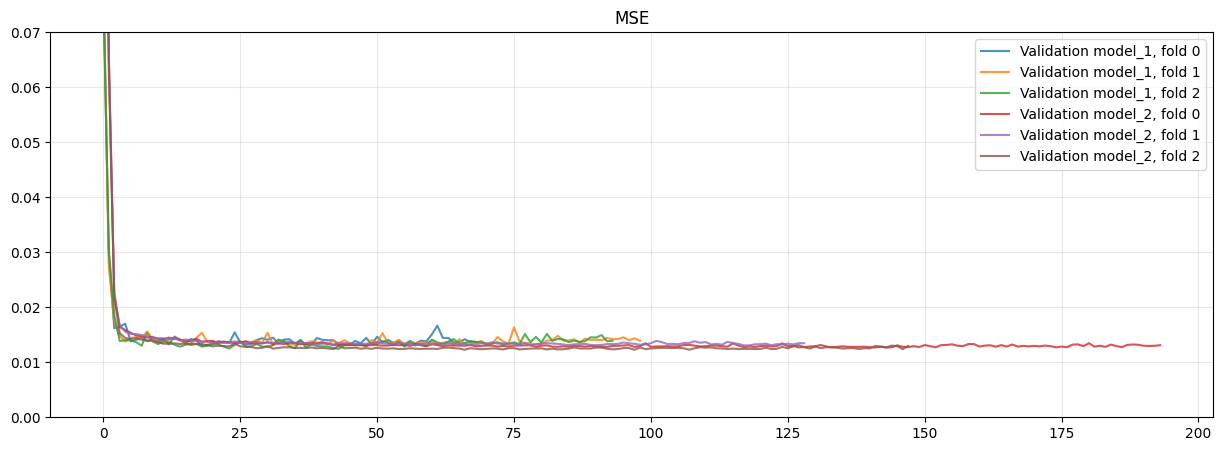

In [ ]:
plt.figure(figsize=(15,5))
for i, exp in enumerate(experiments):
  for fold in exp.fold_experiments:
    plt.plot(fold.val_loss_values, label = f"Validation {fold.name}, fold {fold.fold_number}", alpha = exp.alpha)
plt.ylim(0, 0.07)
plt.title('MSE')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

5. Scegliere la rete migliore


In [ ]:
for exp in experiments:
  exp.val_mse = mean(list(map(lambda x: x.val_mse, exp.fold_experiments)))
  print(f"Model {exp.name}, MSE {exp.val_mse}")

Model model_1, MSE 0.012874423215786615
Model model_2, MSE 0.012799015579124292


In [ ]:
best_exp = list(sorted(experiments, key=lambda x: x.val_mse))[0]

In [ ]:
best_exp.name

'model_2'

6. Allenare nuovamente la rete con gli hyperparameters scelti con un nuovo validation set e Early Stopping


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size = len(X_test),
                                                  random_state=seed, stratify=y_train_val)

In [ ]:
batch_size = 512

train_dataset = data_utils.TensorDataset(torch.tensor(X_train.values, dtype = torch.float32), torch.tensor(y_train.values, dtype = torch.float32))
trainloader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = data_utils.TensorDataset(torch.tensor(X_val.values, dtype = torch.float32), torch.tensor(y_val.values, dtype = torch.float32))
valloader = data_utils.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
best_exp.valloader = valloader
best_exp.trainloader = trainloader

In [ ]:
train_experiment(best_exp)

Epoca: 0 |  Train Loss: 0.17537498474121094 | Val Loss: 0.19975654780864716 
Epoca: 1 |  Train Loss: 0.06488803774118423 | Val Loss: 0.12487337738275528 
Epoca: 2 |  Train Loss: 0.023903023451566696 | Val Loss: 0.06378573179244995 
Epoca: 3 |  Train Loss: 0.01737607643008232 | Val Loss: 0.02897094562649727 
Epoca: 4 |  Train Loss: 0.01830587536096573 | Val Loss: 0.017961036413908005 
Epoca: 5 |  Train Loss: 0.015825847163796425 | Val Loss: 0.01591215841472149 
Epoca: 6 |  Train Loss: 0.015287267975509167 | Val Loss: 0.015805263072252274 
Epoca: 7 |  Train Loss: 0.01461049821227789 | Val Loss: 0.014854149892926216 
Epoca: 8 |  Train Loss: 0.014951158314943314 | Val Loss: 0.014825686812400818 
Epoca: 9 |  Train Loss: 0.013987609185278416 | Val Loss: 0.01464224886149168 
Epoca: 10 |  Train Loss: 0.014282920397818089 | Val Loss: 0.014226721599698067 
Epoca: 11 |  Train Loss: 0.01399583276361227 | Val Loss: 0.014351770281791687 
Epoca: 12 |  Train Loss: 0.013742785900831223 | Val Loss: 0.01

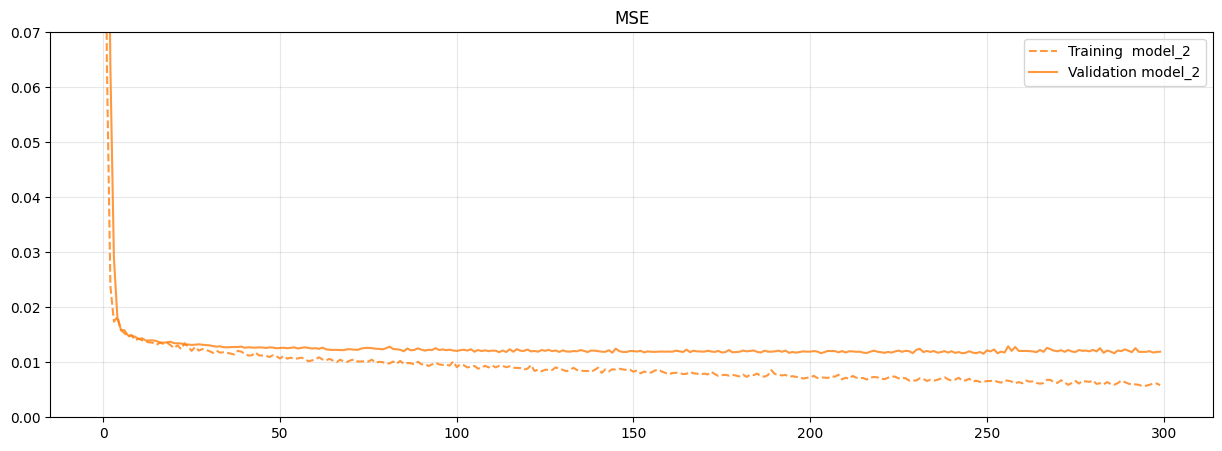

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(best_exp.train_loss_values, label=f'Training  {best_exp.name}',  linestyle = '--', color=exp.color, alpha = exp.alpha)
plt.plot(best_exp.val_loss_values, label = f"Validation {best_exp.name}", color=exp.color, alpha = exp.alpha)
plt.ylim(0, 0.07)
plt.title('MSE')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

7. Testare la rete ottenuta

In [ ]:
testloader = data_utils.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
test_mse = test_experiment(best_exp, testloader)
print(f"Best model {best_exp.name}, test MSE: {test_mse}")

Best model model_2, test MSE: 0.011366806924343109
